## Data 620 Project 3

Farhana Zahir, Benjamin Horvath, Luisa Velasco, Corey Arnouts, Shovan Biswas, Jimmy Ng, 
Randy Thompson, Sam Cohen-Devries, Joby John

Youtube: https://youtu.be/Y-Sux3xq5G8

**Description**

Using any of the three classifiers described in chapter 6 of Natural Language Processing with Python, and any features you can think of, build the best name gender classifier you can.

Begin by splitting the Names Corpus into three subsets: 500 words for the test set, 500 words for the dev-test set, and the remaining 6900 words for the training set. Then, starting with the example name gender classifier, make incremental improvements. Use the dev-test set to check your progress. Once you are satisfied with your classifier, check its final performance on the test set.

How does the performance on the test set compare to the performance on the dev-test set? Is this what you'd expect?

Source: Natural Lnaguage Processing with Python, exercise 6.10.2

In [57]:
# import packages required
import collections
import random
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.classify import apply_features
from nltk.corpus import names
from nltk.metrics import ConfusionMatrix, accuracy, precision, recall, f_measure
%matplotlib inline

**Load dataset**

The `names` dataset is built into the `nltk` package:

In [58]:
# check the corpus, there are two files, female.txt and male.txt
names = nltk.corpus.names
names.fileids()

['female.txt', 'male.txt']

In [59]:
len(names.words('female.txt')), len(names.words('male.txt'))

(5001, 2943)

We see there are nearly twice as many female names as male in this data set.

Comparing the frequency distributions of beginning letters by gender, we see that more female names start with the first letters A, C, M and S. 

The last names do follow what is set in the textbook, names ending in A, E and I tend to be female. However, names ending in L, N and S tend to be male here, whereas the textbook in section 2.4 finds that names ending in K, O, R, S and T tend to be male.

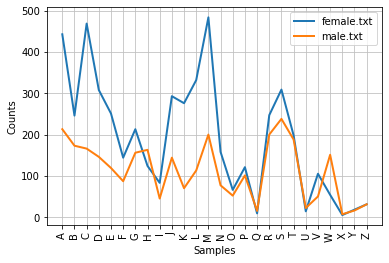

In [60]:
# Check distribution for first letter of name
gender_freq = nltk.ConditionalFreqDist((fileid, name[0])
    for fileid in names.fileids()
    for name in names.words(fileid))
gender_freq.plot()

The same exercise can be applied to the last letter of names. Overwhelmingly, names that end in A, E, and I are female. Although it's hard to see from this representation, it appears that names that end N and Y may be more likely to be male.

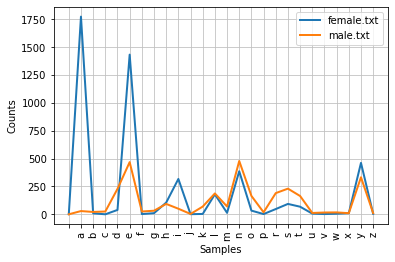

In [61]:
# Check distribution for last letter of name
gender_freq = nltk.ConditionalFreqDist((fileid, name[-1])
    for fileid in names.fileids()
    for name in names.words(fileid))
gender_freq.plot()

**Data Cleaning and Exploration**

We will first merge the two text files and shuffle them. Then we divide as follows:

__Development set:__

6214 names for the training (train_names)
500 names for the testing (devtest_names)

__Test set:__

500 names for the testing (test_names)
The training set is used to train the model, and the dev-test set is used to perform error analysis. The test set serves in our final evaluation of the model.

Models are trained on the training set and then the development set is used to evaluate it for further modification. The final evaluation is on the test set, which was not used for model training at all, and thus model performance on the test set can be taken as a close estimate of the model's performance in reality.

In [62]:
# Merge the two text files and shuffle
names = ([(name, 'male') for name in names.words('male.txt')] + 
        [(name, 'female') for name in names.words('female.txt')])

random.seed(1804)
random.shuffle(names)
names[1:10]

[('Antonetta', 'female'),
 ('Roana', 'female'),
 ('Tarrah', 'female'),
 ('Leoine', 'female'),
 ('Rab', 'male'),
 ('Waldo', 'male'),
 ('Nelia', 'female'),
 ('Ardra', 'female'),
 ('Jud', 'male')]

In [63]:
# see number of unique names
len(set(item[0] for item in names))

7579

One issue we have to deal with is that some names are listed as both male and female. They are removed entirely.

In [64]:
# Generate name distribution and show names that are not unique
names_only = [item[0] for item in names]
names_dist = nltk.FreqDist(names_only)
names_dupes = [(k,v) for k,v in names_dist.items() if v >1]
names_dupes

[('Cat', 2),
 ('Carlin', 2),
 ('Freddy', 2),
 ('Tommy', 2),
 ('Kerry', 2),
 ('Tommie', 2),
 ('Christian', 2),
 ('Jerrie', 2),
 ('Allie', 2),
 ('Chris', 2),
 ('Meryl', 2),
 ('Blair', 2),
 ('Mel', 2),
 ('Mickie', 2),
 ('Rey', 2),
 ('Georgie', 2),
 ('Abbey', 2),
 ('Francis', 2),
 ('Valentine', 2),
 ('Haley', 2),
 ('Jordan', 2),
 ('Addie', 2),
 ('Felice', 2),
 ('Deane', 2),
 ('Tammie', 2),
 ('Bo', 2),
 ('Virgie', 2),
 ('Dory', 2),
 ('Tally', 2),
 ('Carmine', 2),
 ('Vin', 2),
 ('Donny', 2),
 ('Constantine', 2),
 ('Averil', 2),
 ('Marty', 2),
 ('Christie', 2),
 ('Dell', 2),
 ('Val', 2),
 ('Brett', 2),
 ('Ira', 2),
 ('Kelsey', 2),
 ('Tobie', 2),
 ('Dionis', 2),
 ('Andy', 2),
 ('Fran', 2),
 ('Lin', 2),
 ('Ronnie', 2),
 ('Evelyn', 2),
 ('Jody', 2),
 ('Chad', 2),
 ('Theo', 2),
 ('Michele', 2),
 ('Tate', 2),
 ('Wynn', 2),
 ('Jodie', 2),
 ('Ollie', 2),
 ('Matty', 2),
 ('Pooh', 2),
 ('Meade', 2),
 ('Patrice', 2),
 ('Joey', 2),
 ('Glenn', 2),
 ('Fred', 2),
 ('Sayre', 2),
 ('Alix', 2),
 ('Lesley', 2)

In [65]:
# looking at sample duplicates
[item for item in names if item[0] in ["Franky","Quentin","Abbie"]]

[('Abbie', 'female'),
 ('Franky', 'female'),
 ('Quentin', 'male'),
 ('Abbie', 'male'),
 ('Franky', 'male'),
 ('Quentin', 'female')]

In [66]:
# Remove the duplicates and show total number of unique names
names2remove = [item[0] for item in names_dupes]
final_names = [item for item in names if not item[0] in names2remove]
len(final_names)

7214

Finally, split the data set, and examine the gender imbalance in the training set:

In [67]:
test = final_names[0:500]
devtest = final_names[500:1000]
train = final_names[1000:]

# Confirm the size of the three subsets
print("Training Set = {}".format(len(train)))
print("Dev-Test Set = {}".format(len(devtest)))
print("Test Set = {}".format(len(test)))

Training Set = 6214
Dev-Test Set = 500
Test Set = 500


In [68]:
#C heck the distribution of females vs males in the train dataset
train_dist = [g  for (n, g) in train]
nltk.FreqDist(train_dist)

#As expected there are a lot more female names than male names in the dataset.

FreqDist({'female': 3997, 'male': 2217})

**Classification using Naive Bayes**

We subject SEVEN different feature sets to a Naive Bayes classifier. The classifier uses the feature set to predict whether a name is female or male. We study the predictive power of the first and last letters of a name, the last letter, the last two letters, a series of bi- and trigrams made up of names, and finally counts of syllables.

Because of the gender imbalance in the data set, accuracy may provide a skewed evaluation. In addition to accuracy, recall and precision are reported for each class via a custom function.

* Precision -- Signifying false positives, i.e., improved precision indicates fewer false positives.

* Recall -- Measures false negatives, i.e., improved recall indicates fewer false negatives.

Naturally these two measures are often at odds with eachother.


In [69]:
def performance_metrics(model, train, digits=4):
    """Prints the precision and recall of an NLTK Naive Bayes model."""
    reference = collections.defaultdict(set)
    test = collections.defaultdict(set)
    
    for i, (features, label) in enumerate(train):
        reference[label].add(i)
        pred = model.classify(features)
        test[pred].add(i)
        
    m_precision = round(precision(reference['male'], test['male']), digits)
    f_precision = round(precision(reference['female'], test['female']), digits)
    
    m_recall = round(recall(reference['male'], test['male']), digits)
    f_recall = round( recall(reference['female'], test['female']), digits)
        
    print('Male precision: ', m_precision)
    print('Female precision: ', f_precision)
    print('Male recall: ', m_recall)
    print('Female recall: ', f_recall)

**Feature 1: First vs Last Letter**

We will test whether using first letter or last letter gives us a better  results. We fidn that using the last letter improves performance of both the datasets.

First, develop a function to extract the first letter of a string:

In [70]:
# Feature 1 first letter
def first_letter(name):
    name = name.lower()
    return {
        'first_1_letter': name[0]
        }
first_letter("Mary")

{'first_1_letter': 'm'}

In [71]:
train_set = [(first_letter(n), g) for (n,g) in train]
devtest_set = [(first_letter(n), g) for (n,g) in devtest]
test_set = [(first_letter(n), g) for (n,g) in test]
nb1 = nltk.NaiveBayesClassifier.train(train_set) 

print('Devset accuracy is')
print(nltk.classify.accuracy(nb1, devtest_set))
print('Test accuracy is')
print(nltk.classify.accuracy(nb1, test_set))

Devset accuracy is
0.662
Test accuracy is
0.648


In [72]:
performance_metrics(nb1, train_set)

Male precision:  0.6532
Female precision:  0.666
Male recall:  0.1308
Female recall:  0.9615


In [73]:
performance_metrics(nb1, devtest_set)

Male precision:  0.6389
Female precision:  0.6638
Male recall:  0.1285
Female recall:  0.9595


There is not much difference between the train and development sets, indicating it is unlikely the model is overfitting the data.

What is most striking is how many false negatives the model performs on male names. The model is biased toward females names, over-classifying male names as female. Because of this, the model has a great recall on female names of nearly 1.0.

The model determines the most informative feature is beginning with a W, much more likely to be male than female. Q, K, U, H, and X are also fairly informative.

In [74]:
# Looking at the most informative features
nb1.show_most_informative_features(10) 

Most Informative Features
          first_1_letter = 'w'              male : female =      6.2 : 1.0
          first_1_letter = 'q'              male : female =      3.8 : 1.0
          first_1_letter = 'k'            female : male   =      2.5 : 1.0
          first_1_letter = 'u'              male : female =      2.5 : 1.0
          first_1_letter = 'h'              male : female =      2.4 : 1.0
          first_1_letter = 'x'              male : female =      2.2 : 1.0
          first_1_letter = 'l'            female : male   =      1.9 : 1.0
          first_1_letter = 'c'            female : male   =      1.9 : 1.0
          first_1_letter = 'z'              male : female =      1.7 : 1.0
          first_1_letter = 'y'              male : female =      1.7 : 1.0


**Feature 2: Last Letter**

In [75]:
#Feature 2 last letter
def last_letter(name):
    name = name.lower()
    return {
        'last_1_letter': name[-1]
        }
last_letter("Mary")

{'last_1_letter': 'y'}

In [76]:
train_set = [(last_letter(n), g) for (n,g) in train]
devtest_set = [(last_letter(n), g) for (n,g) in devtest]
test_set = [(last_letter(n), g) for (n,g) in test]
nb2 = nltk.NaiveBayesClassifier.train(train_set) 
print('Devset accuracy is')
print(nltk.classify.accuracy(nb2, devtest_set))
print('Test accuracy is')
print(nltk.classify.accuracy(nb2, test_set))

Devset accuracy is
0.778
Test accuracy is
0.786


In [77]:
performance_metrics(nb2, train_set)

Male precision:  0.7032
Female precision:  0.8404
Male recall:  0.7149
Female recall:  0.8326


In [78]:
performance_metrics(nb2, devtest_set)

Male precision:  0.6735
Female precision:  0.8454
Male recall:  0.7374
Female recall:  0.8006


Possibly slight overfitting, but hardly a worrying amount. Recall and precision for both classes are vastly superior to the first model. By itself, it appears the last letter is an excellent feature for the present purpose.

Examining the most informative features, we can see the top odds are much greater than before. A name that starts with K is over 73 times more likely to be male than female! Even the tenth ratio is 6.1 : 1.0!

In [79]:
#Looking at the most informative features
nb2.show_most_informative_features(10) 

Most Informative Features
           last_1_letter = 'k'              male : female =     71.3 : 1.0
           last_1_letter = 'a'            female : male   =     51.8 : 1.0
           last_1_letter = 'm'              male : female =     18.8 : 1.0
           last_1_letter = 'p'              male : female =     16.2 : 1.0
           last_1_letter = 'v'              male : female =     16.2 : 1.0
           last_1_letter = 'f'              male : female =     14.7 : 1.0
           last_1_letter = 'd'              male : female =     11.2 : 1.0
           last_1_letter = 'o'              male : female =     10.3 : 1.0
           last_1_letter = 'r'              male : female =      7.9 : 1.0
           last_1_letter = 'z'              male : female =      6.1 : 1.0


**Feature 3: Last 2 letters**

In [80]:
def last_2_letters(name):
    name = name.lower()
    return {
        'last_2_letters': name[-2:]
        }
last_2_letters("Andy")

{'last_2_letters': 'dy'}

In [81]:
train_set = [(last_2_letters(n), g) for (n,g) in train]
devtest_set = [(last_2_letters(n), g) for (n,g) in devtest]
test_set = [(last_2_letters(n), g) for (n,g) in test]
nb3 = nltk.NaiveBayesClassifier.train(train_set) 
print('Devset accuracy is')
print(nltk.classify.accuracy(nb3, devtest_set))
print('Test accuracy is')
print(nltk.classify.accuracy(nb3, test_set))

Devset accuracy is
0.812
Test accuracy is
0.818


In [82]:
performance_metrics(nb3, train_set)

Male precision:  0.815
Female precision:  0.8414
Male recall:  0.6897
Female recall:  0.9132


In [83]:
performance_metrics(nb3, devtest_set)

Male precision:  0.7815
Female precision:  0.8252
Male recall:  0.6592
Female recall:  0.8972


Slight overfitting, but this model is performing superior to the previous two. The ratio of the most informative features continue to grow:

In [84]:
# Looking at the most informative features
nb3.show_most_informative_features(10) 

Most Informative Features
          last_2_letters = 'na'           female : male   =    145.0 : 1.0
          last_2_letters = 'la'           female : male   =     69.5 : 1.0
          last_2_letters = 'ia'           female : male   =     49.7 : 1.0
          last_2_letters = 'ta'           female : male   =     38.1 : 1.0
          last_2_letters = 'us'             male : female =     34.1 : 1.0
          last_2_letters = 'rt'             male : female =     32.0 : 1.0
          last_2_letters = 'io'             male : female =     26.4 : 1.0
          last_2_letters = 'do'             male : female =     24.0 : 1.0
          last_2_letters = 'rd'             male : female =     23.6 : 1.0
          last_2_letters = 'ld'             male : female =     23.6 : 1.0


**Feature 4: 2 letters as suffix + last trigram + first trigram + first fourgram**

Multiple features are subject to the NB classifier: A name's last letter, last two letters, the last three letters, the first letters, and the first four letters:

In [85]:
def feature4(name):
        name = name.lower()
        return {
            'suffix1': name[-1:],
            'suffix2': name[-2:],
            'last_trigram': name[-3:],
            'first_trigram': name[:3], 
            'first_fourgram': name[:4]
               }
feature4("Mademoiselle")

{'suffix1': 'e',
 'suffix2': 'le',
 'last_trigram': 'lle',
 'first_trigram': 'mad',
 'first_fourgram': 'made'}

In [86]:
train_set = [(feature4(n), g) for (n,g) in train]
devtest_set = [(feature4(n), g) for (n,g) in devtest]
test_set = [(feature4(n), g) for (n,g) in test]
nb4 = nltk.NaiveBayesClassifier.train(train_set) 
print('Devset accuracy is')
print(nltk.classify.accuracy(nb4, devtest_set))
print('Test accuracy is')
print(nltk.classify.accuracy(nb4, test_set))

Devset accuracy is
0.904
Test accuracy is
0.894


In [87]:
performance_metrics(nb4, train_set)

Male precision:  0.9086
Female precision:  0.9668
Male recall:  0.9414
Female recall:  0.9475


In [88]:
performance_metrics(nb4, devtest_set)

Male precision:  0.8359
Female precision:  0.9475
Male recall:  0.9106
Female recall:  0.9003


With all four measures at or above 0.90, this model is classifying almost perfectly. However, the features encoding the last two letters are vastly more important than many of the additions:

In [89]:
# Looking at the most informative features
nb4.show_most_informative_features(10) 

Most Informative Features
                 suffix2 = 'na'           female : male   =    145.0 : 1.0
                 suffix1 = 'k'              male : female =     71.3 : 1.0
                 suffix2 = 'la'           female : male   =     69.5 : 1.0
                 suffix1 = 'a'            female : male   =     51.8 : 1.0
                 suffix2 = 'ia'           female : male   =     49.7 : 1.0
                 suffix2 = 'ta'           female : male   =     38.1 : 1.0
                 suffix2 = 'us'             male : female =     34.1 : 1.0
                 suffix2 = 'rt'             male : female =     32.0 : 1.0
                 suffix2 = 'io'             male : female =     26.4 : 1.0
                 suffix2 = 'do'             male : female =     24.0 : 1.0


**Features 5, 6, 7: Syllable Count**

Additional Feature Engineering Based off of this work: 
https://arxiv.org/pdf/1606.05467.pdf

In this feature generation instead of just looking the prescence and count of every character instead we opted to group characters by Kiki and Bouba characters which are groupings of letters based off the way they are pronounced.

We found some interesting reading on Bouba vs Kiki as well
https://en.wikipedia.org/wiki/Bouba/kiki_effect
https://www.scientificamerican.com/article/bring-science-home-bouba-kiki-effect/

In the feature engineering below we also brought in the syllable count.


In [90]:
#function for syllable count
def syllable_count(word):
    word = word.lower()
    count = 0
    vowels = "aeiouy"
    if word[0] in vowels:
        count += 1
    for index in range(1, len(word)):
        if word[index] in vowels and word[index - 1] not in vowels:
            count += 1
    if word.endswith("e"):
        count -= 1
    if count == 0:
        count += 1
    return count


In [91]:
#Final function including kiki, bouba letters
def get_features(name):
        name=name.lower()
        return {
            'suffix1': name[-1:],
            'suffix2': name[-2:],
            'last_trigram': name[-3:],
            'first_trigram': name[:3], 
            'first_fourgram': name[:4],
            'bouba_letters': len([v for v in name if v in 'blmnuo']),
            'kiki_letters':len([v for v in name if v in 'kptiezv']),
            'syllable_count':syllable_count(name)
            
               }
get_features("Mademoiselle")

{'suffix1': 'e',
 'suffix2': 'le',
 'last_trigram': 'lle',
 'first_trigram': 'mad',
 'first_fourgram': 'made',
 'bouba_letters': 5,
 'kiki_letters': 4,
 'syllable_count': 4}

In [92]:
train_set = [(get_features(n), g) for (n,g) in train]
devtest_set = [(get_features(n), g) for (n,g) in devtest]
test_set = [(get_features(n), g) for (n,g) in test]
classifier = nltk.NaiveBayesClassifier.train(train_set) 
print('Devset accuracy is')
print(nltk.classify.accuracy(classifier, devtest_set))
print('Test accuracy is')
print(nltk.classify.accuracy(classifier, test_set))

Devset accuracy is
0.908
Test accuracy is
0.892


In [93]:
performance_metrics(classifier, train_set)

Male precision:  0.9054
Female precision:  0.9665
Male recall:  0.9409
Female recall:  0.9455


In [94]:
performance_metrics(classifier, devtest_set)

Male precision:  0.8342
Female precision:  0.9568
Male recall:  0.9274
Female recall:  0.8972


Interestingly, this model does not appear to perform any better compared to the previous model, despite the most sophisticated feature engineering. An examination of the most informative features indicates why: Bouba and Kiki letters and syllable count barely register in the top features.

In [95]:
classifier.show_most_informative_features(10)

Most Informative Features
                 suffix2 = 'na'           female : male   =    145.0 : 1.0
                 suffix1 = 'k'              male : female =     71.3 : 1.0
                 suffix2 = 'la'           female : male   =     69.5 : 1.0
                 suffix1 = 'a'            female : male   =     51.8 : 1.0
                 suffix2 = 'ia'           female : male   =     49.7 : 1.0
                 suffix2 = 'ta'           female : male   =     38.1 : 1.0
                 suffix2 = 'us'             male : female =     34.1 : 1.0
                 suffix2 = 'rt'             male : female =     32.0 : 1.0
                 suffix2 = 'io'             male : female =     26.4 : 1.0
                 suffix2 = 'do'             male : female =     24.0 : 1.0


**Error analysis on devtest**

In [96]:
#Function to generate errors
def generate_errors(classifier, dataset): 
    
    errors = [] 

    for (name, tag) in dataset:
        guess = classifier.classify(get_features(name)) 
        if guess != tag: 
            errors.append((tag, guess, name))
            
    return errors
#Function to print error
def show_errors(errors, n = None):
   
    if n is not None: errors = errors[:n]
            
    for (tag, guess, name) in sorted(errors): 
        print('correct=%-8s guess=%-8s name=%-30s' %(tag, guess, name))
    print(len(errors))

In [97]:
# Show error in devtest
show_errors(generate_errors(classifier, devtest))

correct=female   guess=male     name=Bess                          
correct=female   guess=male     name=Buffy                         
correct=female   guess=male     name=Christan                      
correct=female   guess=male     name=Clio                          
correct=female   guess=male     name=Devan                         
correct=female   guess=male     name=Doloritas                     
correct=female   guess=male     name=Em                            
correct=female   guess=male     name=Eran                          
correct=female   guess=male     name=Ethel                         
correct=female   guess=male     name=Farrand                       
correct=female   guess=male     name=Frances                       
correct=female   guess=male     name=Gates                         
correct=female   guess=male     name=Germain                       
correct=female   guess=male     name=Gillan                        
correct=female   guess=male     name=Gusty      

Out of 500 names, we have incorrectly classified 46 names. This is expected from the calculated accuracy rate of the classifier on the devtest dataset.

**Confusion matrix for Devtest**

In [98]:
#Function to generate prediction
def generate_prediction(classifier, dataset): 
    
    classification = [] 

    for (name, tag) in dataset:
        guess = classifier.classify(get_features(name)) 
        classification.append((name,guess))
            
    return classification

In [99]:
devtest1=generate_prediction(classifier, devtest)
devtest1[25]

('Brandice', 'female')

In [100]:
#Function to generate confusion matrix and accuracy indicators
def accuracy(actual, predicted):
    test_result = []
    gold_result = []

    for i in range(len(actual)):
        test_result.append(predicted[i][1])
        gold_result.append(actual[i][1])
    
    CM = nltk.ConfusionMatrix(gold_result, test_result)
    print(CM)

    labels = ('female', 'male')

    from collections import Counter
    TP, FN, FP = Counter(), Counter(), Counter()
    for i in labels:
        for j in labels:
            if i == j:
                TP[i] += int(CM[i,j])
            else:
                FN[i] += int(CM[i,j])
                FP[j] += int(CM[i,j])

    print("label\tprecision\trecall\tf_measure")
    for label in sorted(labels):
        precision, recall = 0, 0
        if TP[label] == 0:
            f_measure = 0
        else:
            precision = float(TP[label]) / (TP[label]+FP[label])
            recall = float(TP[label]) / (TP[label]+FN[label])
            f_measure = float(2) * (precision * recall) / (precision + recall)
        print(label+"\t"+str("{:.5f}".format(precision))+"\t"+str("{:.5f}".format(recall))+"\t"+str("{:.5f}".format(f_measure)))
            

#Ref: https://stackoverflow.com/questions/38541644/confusion-matrix-testing-sentiment-analysis-model

In [101]:
accuracy(devtest, devtest1)

       |   f     |
       |   e     |
       |   m   m |
       |   a   a |
       |   l   l |
       |   e   e |
-------+---------+
female |<288> 33 |
  male |  13<166>|
-------+---------+
(row = reference; col = test)

label	precision	recall	f_measure
female	0.95681	0.89720	0.92605
male	0.83417	0.92737	0.87831


**Confusion matrix for test**

In [102]:
#show errors
show_errors(generate_errors(classifier, test))

correct=female   guess=male     name=Ambur                         
correct=female   guess=male     name=Bab                           
correct=female   guess=male     name=Barb                          
correct=female   guess=male     name=Bev                           
correct=female   guess=male     name=Cher                          
correct=female   guess=male     name=Chicky                        
correct=female   guess=male     name=Cloris                        
correct=female   guess=male     name=Ealasaid                      
correct=female   guess=male     name=Eilis                         
correct=female   guess=male     name=Gilligan                      
correct=female   guess=male     name=Hannis                        
correct=female   guess=male     name=Harriet                       
correct=female   guess=male     name=Harriott                      
correct=female   guess=male     name=Hester                        
correct=female   guess=male     name=Hesther    

In [103]:
test1 = generate_prediction(classifier, test)
accuracy(test, test1)

       |   f     |
       |   e     |
       |   m   m |
       |   a   a |
       |   l   l |
       |   e   e |
-------+---------+
female |<284> 34 |
  male |  20<162>|
-------+---------+
(row = reference; col = test)

label	precision	recall	f_measure
female	0.93421	0.89308	0.91318
male	0.82653	0.89011	0.85714


**How does the performance on the test set compare to the performance on the dev-test set? Is this what you would expect?**


In [104]:
# Summary of the features 

def summary(nruns, feature_function): #nruns=no of runs, feature_function= feature to be used
    accuracy_df = {
        "classifier": [],
        "train_accuracy": [],
        "test_accuracy": [],
        "devtest_accuracy": [],
        "devtest_errors": []
    }
    for i in range(nruns):
        random.shuffle(final_names)
        accuracy_test = final_names[:500]
        accuracy_devtest = final_names[500:1000]
        accuracy_train = final_names[1000:]
        
            
        accuracy_trainset = [(feature_function(n), g) for (n,g) in accuracy_train]
        accuracy_devtestset = [(feature_function(n), g) for (n,g) in accuracy_devtest]
        accuracy_testset = [(feature_function(n), g) for (n,g) in accuracy_test]
        
        accuracy_classifier = nltk.NaiveBayesClassifier.train(accuracy_trainset)
        accuracy_df["classifier"].append(accuracy_classifier)
        accuracy_df["train_accuracy"].append(nltk.classify.accuracy(accuracy_classifier, accuracy_trainset))
        accuracy_df["test_accuracy"].append(nltk.classify.accuracy(accuracy_classifier, accuracy_testset))
        accuracy_df["devtest_accuracy"].append(nltk.classify.accuracy(accuracy_classifier, accuracy_devtestset))
        
        accuracy_errors = []
        for (name, tag) in accuracy_devtest:
            accuracy_guess = accuracy_classifier.classify(feature_function(name))
            if accuracy_guess != tag:
                accuracy_errors.append( (tag, accuracy_guess, name) )
        accuracy_df["devtest_errors"].append(accuracy_errors)
        
    accuracy_df = pd.DataFrame.from_dict(accuracy_df)
    return(accuracy_df)

In [ ]:
summary = summary(100, get_features)
summary.describe()

**How does the performance on the test set compare to the performance on the dev-test set? Is this what you'd expect?**

We would expect that the accuracy indicators for devtest and test to be close to each other, as we have shuffled the datasets. In the above table, we have run the feature function we generated 100 times, every time with the final_names shuffled. We see accuracy go down from 94.5% for train to 89% for devtest and test. The summary measures for test_accuracy and devtest_accuracy are very close to each other, confirming our expectation.

Let us now test this on a different dataset, amuch bigger one. The dataset can be found at https://data.world/len/us-first-names-database and containd 32,952 names. The csv has been uploaded at https://github.com/ShovanBiswas/DATA620/blob/master/Week09/test2.csv

In [ ]:
test2 = pd.read_csv('https://raw.githubusercontent.com/ShovanBiswas/DATA620/master/Week09/test2.csv')
test2 = test2.values.tolist()


In [ ]:
test2_set = [(get_features(n), g) for (n,g) in test2]
classifier = nltk.NaiveBayesClassifier.train(test2_set) 
print('Accuracy is')
print(nltk.classify.accuracy(classifier, test2_set))

In [53]:
#predict for the test data
test2_predict = generate_prediction(classifier, test2)

In [56]:
accuracy(test2, test2_predict)

       |     f       |
       |     e       |
       |     m     m |
       |     a     a |
       |     l     l |
       |     e     e |
-------+-------------+
female |<16363> 2630 |
  male |  1962<11997>|
-------+-------------+
(row = reference; col = test)

label	precision	recall	f_measure
female	0.89293	0.86153	0.87695
male	0.82020	0.85945	0.83936


We get an 86% accuracy, which is lower than our original test dataset at 89%, but does not differ significantly.